In [1]:
import numpy as np
from env.blackjack import BlackjackEnv
from collections import defaultdict

In [2]:
env = BlackjackEnv()
obs_dim = env.observation_space
action_dim = env.action_space
print(f"obs_dim:{obs_dim},action_dim:{action_dim}")

obs_dim:Tuple(Discrete(32), Discrete(11), Discrete(2)),action_dim:Discrete(2)


In [3]:
def sample_policy(observation):
    # 待评估价值的策略
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [4]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    values = defaultdict(float)
    
    for i_episode in range(num_episodes):
        episode = []
        state = env.reset()
        for step in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                # print(f"episode_length:{step+1}")
                break
            state = next_state

        # 将state转化成tuple，可作为字典的键
        states_in_episode = [tuple(x[0]) for x in episode]
        for state in states_in_episode:
            # 确定state第一次出现的序号
            for i, data in enumerate(episode):
                if data[0] == state:
                    first_occurence_idx = i 
            # 计算平均return
            G = 0
            for i, data in enumerate(episode[first_occurence_idx:]):
                G += data[2]*(discount_factor**i)
            returns_sum[state] += G
            returns_count[state] += 1.0
            values[state] = returns_sum[state] / returns_count[state]

    return values 

#### 蒙特卡洛预测
+ 定义：已知某固定策略，获取该策略下所有状态的价值
+ 如果某个状态出现多次，则只考虑计算第一次出现时的状态价值
+ 基于均值的估计方法是无偏的
+ 不需要已知环境的转移概率矩阵

In [5]:
def plot_value_function(V, title="Value Function"):
    from matplotlib import pyplot as plt
    import matplotlib
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Holding')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

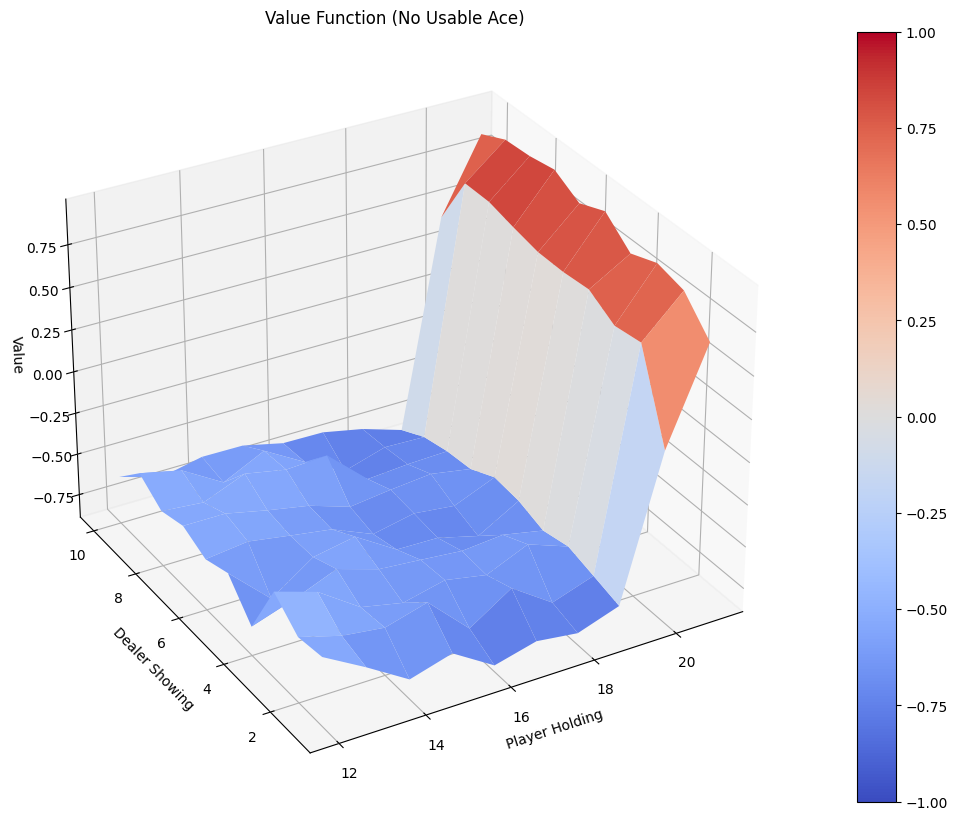

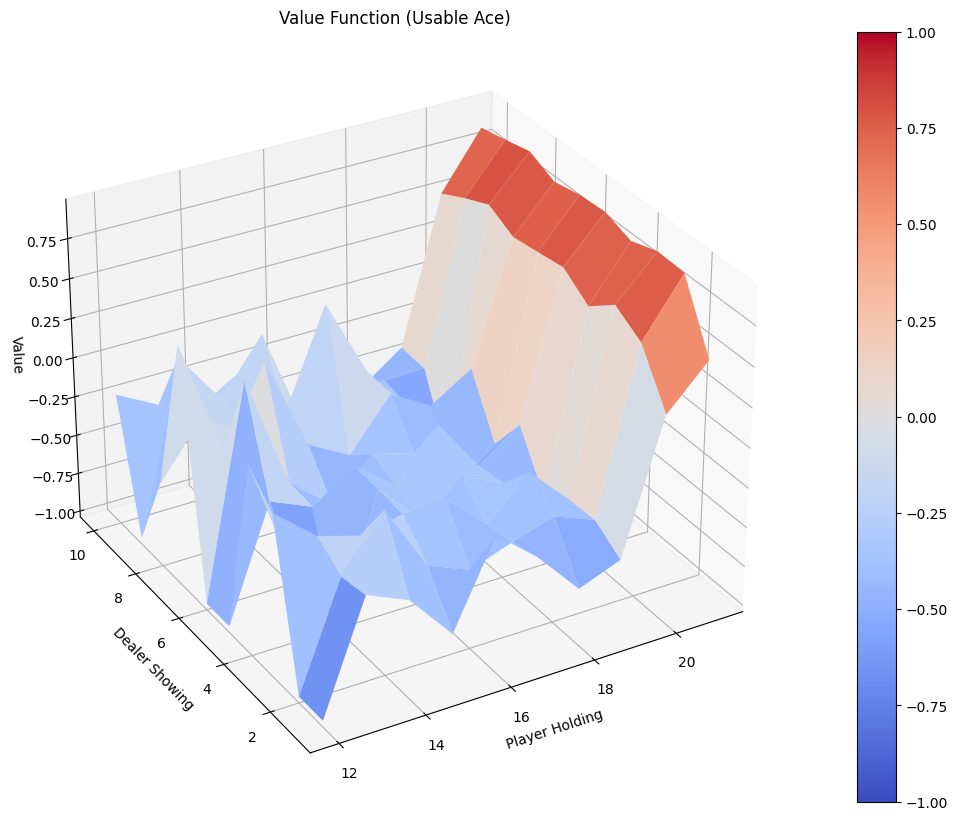

In [6]:
Value_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plot_value_function(Value_10k)